In [8]:
#### آوردن داده از یک گیت هاب
!git clone https://github.com/Alireza-Akhavan/object-detection-notebooks.git

Cloning into 'object-detection-notebooks'...
remote: Enumerating objects: 2083, done.
remote: Counting objects: 100% (2083/2083), done.
remote: Compressing objects: 100% (2078/2078), done.
remote: Total 2083 (delta 9), reused 2069 (delta 2), pack-reused 0
Receiving objects: 100% (2083/2083), 26.78 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (9/9), done.


This notebook is part of "Object detection course":
    https://github.com/Alireza-Akhavan/object-detection-notebooks

این یک مساله رگرشنه و میخواد مساحت در برگیرنده ایکس و ایگرگی که گفته شده رو محاسبه کنه

In [10]:
#### من از نوت بوکی کاآورده همشو نمیخوام فقط یکی شو میخوام

!mv object-detection-notebooks/dataset . #### بردار این دیتاست و بذار همینجا باشه

mv: cannot move 'object-detection-notebooks/dataset' to './dataset': Directory not empty


In [11]:
!rm -r object-detection-notebooks/ ### حالا که قایل دلخواهمو از این پوشه برداشتم و کشیدم کنار حالا این فولدر و پاک کن

In [12]:
### ورژن تنسرفلو هست
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.15.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [14]:
BASE_PATH = "dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])

In [15]:
rows = open(ANNOTS_PATH).read().strip().split("\n")

In [16]:
rows

['image_0001.jpg,49,30,349,137',
 'image_0002.jpg,59,35,342,153',
 'image_0003.jpg,47,36,331,135',
 'image_0004.jpg,47,24,342,141',
 'image_0005.jpg,48,18,339,146',
 'image_0006.jpg,48,24,344,126',
 'image_0007.jpg,49,23,344,122',
 'image_0008.jpg,51,29,344,119',
 'image_0009.jpg,50,29,344,137',
 'image_0010.jpg,55,32,335,106',
 'image_0011.jpg,58,35,344,130',
 'image_0012.jpg,49,25,344,122',
 'image_0013.jpg,48,31,344,146',
 'image_0014.jpg,55,37,349,121',
 'image_0015.jpg,61,39,353,163',
 'image_0016.jpg,59,54,327,137',
 'image_0017.jpg,62,37,347,143',
 'image_0018.jpg,57,33,348,147',
 'image_0019.jpg,51,33,341,146',
 'image_0020.jpg,45,31,345,165',
 'image_0021.jpg,48,28,347,129',
 'image_0022.jpg,49,30,344,130',
 'image_0023.jpg,50,23,341,121',
 'image_0024.jpg,48,25,344,106',
 'image_0025.jpg,56,31,342,140',
 'image_0026.jpg,59,30,337,127',
 'image_0027.jpg,53,25,348,123',
 'image_0028.jpg,54,29,346,114',
 'image_0029.jpg,56,29,348,119',
 'image_0030.jpg,47,15,354,161',
 'image_00

In [17]:
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = [] #### خود ایمیج
targets = [] ### اون چهارتایی ایکس و ایگرگ
filenames = [] #### اسم فایل

In [18]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    (filename, startX, startY, endX, endY) = row.split(",")

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    #### دلیلش اینه که تقسیم می کنیم اینه که با تغییر سایز عکس تو این موارد ، این نقاط معناشون تغییر نکنه
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [19]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [20]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [21]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 3s 0us/step


In [23]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add( Dense(128, activation="relu"))
model.add( Dense(64, activation="relu"))
model.add( Dense(32, activation="relu"))
model.add( Dense(4, activation="sigmoid"))

### چهار تا لایه چون قراره چها نقطه رو پیش بینی کنه و سیگوید چون بین صفر و یکه

In [24]:
vgg.trainable = False

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17936548 (68.42 MB)
Trainable params: 32

In [27]:
opt = Adam(lr=1e-4)
model.compile(loss="mse", optimizer=opt)

### چون اینجا اختلاف مهمه، مثلا مهمه که 2 رو 3 نگه

In [28]:
H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=32,
epochs=25,
verbose=1)

Epoch 1/25
23/23 [==============================] - 20s 378ms/step - loss: 0.0308 - val_loss: 0.0297
Epoch 2/25
23/23 [==============================] - 4s 177ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 3/25
23/23 [==============================] - 4s 160ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 4/25
23/23 [==============================] - 4s 159ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 5/25
23/23 [==============================] - 4s 157ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 6/25
23/23 [==============================] - 4s 157ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 7/25
23/23 [==============================] - 4s 159ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 8/25
23/23 [==============================] - 4s 155ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 9/25
23/23 [==============================] - 4s 153ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 10/25
23/23 [==============================] - 4s 154ms/step - loss: 0.0299 - val_loss: 0.029

In [29]:
model.save("localization.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


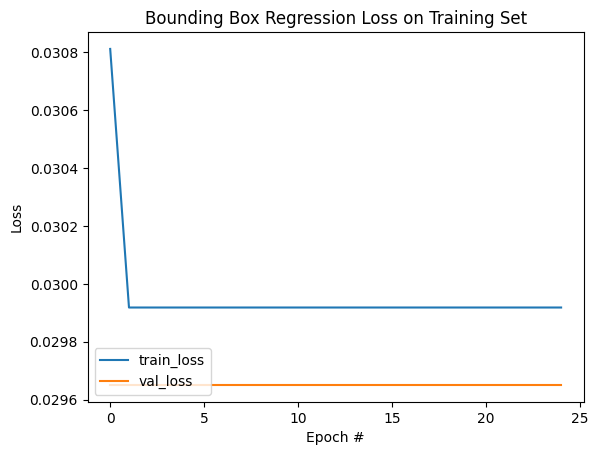

In [30]:
N = H.params['epochs']
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

Source:

https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/